In [1]:
import helper.batterystats as bstats
import helper.cliffs_delta as cliff
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import statistics, os, re

# Load battery data

In [2]:
battery_raw_data = bstats.parse_files("./data")
battery_data = {}

relevant_interactions = ["OpenCloseDrawerInteractionTest", "ScrollDownListInteractionTest", "SwitchScreensInteractionTest", "EnterFormDataInteractionTest"]

interaction_names = {
    "OpenCloseDrawerInteractionTest": "Open/close drawer (i1)",   
    "ScrollDownListInteractionTest": "List scrolling (i2)",
    "SwitchScreensInteractionTest": "Switch screens (i3)",
    "EnterFormDataInteractionTest": "Enter form data (i4)",
}

device_names = ["Nexus5X", "SM-G960F"]

app_names = {
    "chrome": "PWA (Chrome)",
    "firefox": "PWA (Firefox)",
    "react": "React Native",
    "flutter": "Flutter",
    "native": "Android native",
    "capacitor": "Capacitor"
}

app_index = {
    "chrome": 0,
    "react": 4,
    "flutter": 3,
    "native": 5,
    "capacitor": 2,
    "firefox": 1
}

for device, apps in battery_raw_data.items():    
    if device not in device_names:
        continue
    
    for app, interactions in apps.items():                
        for interaction, values in interactions.items():
            if interaction not in relevant_interactions:
                continue
            
            if "{}_{}".format(device, interaction) not in battery_data.keys():
                battery_data["{}_{}".format(device, interaction)] = {
                    "data" : [[],[],[],[],[],[]],
                    "app": ["","","","","",""],
                    "interaction": interaction_names[interaction],
                    "device": device
                }
            
            battery_data["{}_{}".format(device, interaction)]["data"][app_index[app]] = values["app_joule"]
            battery_data["{}_{}".format(device, interaction)]["app"][app_index[app]] = app_names[app]        

# Boxplot energy consumption

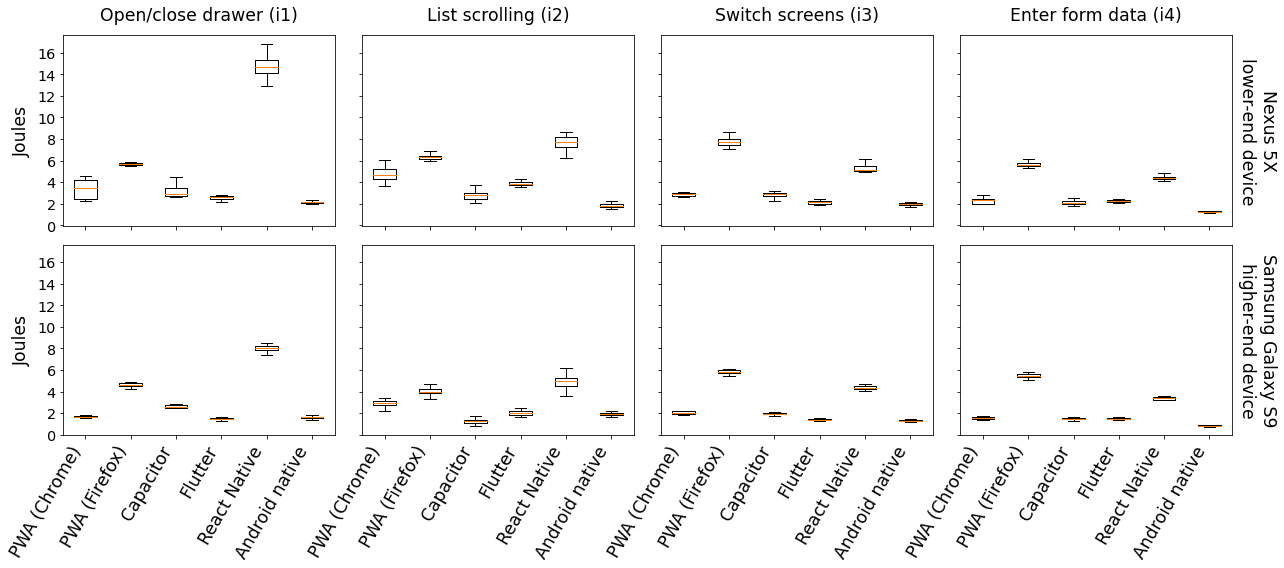

In [11]:
fig, axs = plt.subplots(2, 4, sharey=True, figsize=(18, 8))

device_labels = {
    "Nexus5X": "Nexus 5X\nlower-end device",
    "SM-G960F": "Samsung Galaxy S9\nhigher-end device"
}
keys = [
    "Nexus5X_OpenCloseDrawerInteractionTest",
    "Nexus5X_ScrollDownListInteractionTest",
    "Nexus5X_SwitchScreensInteractionTest",
    "Nexus5X_EnterFormDataInteractionTest",
    "SM-G960F_OpenCloseDrawerInteractionTest",
    "SM-G960F_ScrollDownListInteractionTest",
    "SM-G960F_SwitchScreensInteractionTest",
    "SM-G960F_EnterFormDataInteractionTest",
]

index = 0
for key in keys:    
    item = battery_data[key]
    
    if item['device'] not in ("Nexus5X", "SM-G960F"):
        continue
    # https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.boxplot.html?highlight=boxplot#matplotlib.axes.Axes.boxplot
    
    if index >= 4:
        axs[index // 4, index % 4].boxplot(item["data"], labels=item["app"], sym="", manage_ticks=True, autorange=True) 
    else:
        axs[index // 4, index % 4].boxplot(item["data"], labels=["", "", "", "", "", ""], sym="", manage_ticks=True, autorange=True)
        axs[index // 4, index % 4].set_title(item["interaction"], fontsize='xx-large', pad=15)
    
    if index % 4 == 0:
        axs[index // 4, index % 4].set_ylabel("Joules", rotation=90, labelpad=7, fontsize='xx-large')
    
    if index % 4 == 3:
        axs[index // 4, index % 4].yaxis.set_label_position("right")
        axs[index // 4, index % 4].set_ylabel(device_labels[item['device']], rotation=-90, labelpad=45, fontsize='xx-large')
    
    index += 1

for x in range(4):
    for label in axs[1, x].get_xticklabels():
        label.set_rotation(60)
        label.set_ha('right')
        label.set_fontsize('xx-large')
        
for y in range(2):
    for label in axs[y, 0].get_yticklabels():
        #label.set_rotation(60)
        #label.set_ha('right')
        label.set_fontsize('x-large')         

        
fig.tight_layout()
fig.subplots_adjust(wspace=0.1, hspace=0.1)
fig.savefig('./figures/results.png', dpi=800)

# Shapiro-Wilk test for normality

`p < 0.05` shows evidence for non-normal distribution

In [5]:
all = 0
non_normal = 0

for key, item in battery_data.items():
    print("{}/{}".format(item["device"], item["interaction"]))
    for app, d in zip(item["app"], item["data"]):
        all += 1
        r = stats.shapiro(np.array(d))
        non_normal += (1 if r[1] <= 0.05 else 0)
        print("  {}: p-value={:.5f}".format(app, r[1]))

print("\n{} non-normally distributed samples".format(non_normal))
print("{} normally distributed samples".format(all - non_normal))
print("{:.2f}% non-normally distributed samples".format(non_normal/all*100))        

Nexus5X/Enter form data (i4)
  PWA (Chrome): p-value=0.00000
  PWA (Firefox): p-value=0.00000
  Capacitor: p-value=0.23747
  Flutter: p-value=0.16727
  React Native: p-value=0.02069
  Android native: p-value=0.06858
Nexus5X/Open/close drawer (i1)
  PWA (Chrome): p-value=0.00177
  PWA (Firefox): p-value=0.00000
  Capacitor: p-value=0.00001
  Flutter: p-value=0.01757
  React Native: p-value=0.00033
  Android native: p-value=0.42888
Nexus5X/List scrolling (i2)
  PWA (Chrome): p-value=0.82711
  PWA (Firefox): p-value=0.01369
  Capacitor: p-value=0.00420
  Flutter: p-value=0.01362
  React Native: p-value=0.00000
  Android native: p-value=0.00000
Nexus5X/Switch screens (i3)
  PWA (Chrome): p-value=0.17067
  PWA (Firefox): p-value=0.38587
  Capacitor: p-value=0.13534
  Flutter: p-value=0.89549
  React Native: p-value=0.00000
  Android native: p-value=0.82072
SM-G960F/Enter form data (i4)
  PWA (Chrome): p-value=0.12681
  PWA (Firefox): p-value=0.00426
  Capacitor: p-value=0.01145
  Flutter: p

# Two-sided Mann-Whitney U

 - RQ1: Bonferonni correction means $ a = 0.05/C $, where $ C $ is the number of tests per family (interaction on device)
 - RQ2: $ a = 0.05 $

In [6]:
groups = [[0, 2], [0, 3], [0, 4], [0, 5], [0, 1]]
rq1_alpha = (0.05 / 4)
rq2_alpha = 0.05

keys = [
    "Nexus5X_OpenCloseDrawerInteractionTest",
    "Nexus5X_ScrollDownListInteractionTest",
    "Nexus5X_SwitchScreensInteractionTest",
    "Nexus5X_EnterFormDataInteractionTest",
    "SM-G960F_OpenCloseDrawerInteractionTest",
    "SM-G960F_ScrollDownListInteractionTest",
    "SM-G960F_SwitchScreensInteractionTest",
    "SM-G960F_EnterFormDataInteractionTest",
]

for key in keys:  
    item = battery_data[key]
    print("{} / {}".format(item["device"], item["interaction"]))
    for group in groups:
        u1 = stats.mannwhitneyu(np.array(item["data"][group[0]]), np.array(item["data"][group[1]]), alternative='two-sided')
        u2 = stats.mannwhitneyu(np.array(item["data"][group[1]]), np.array(item["data"][group[1]]), alternative='two-sided')
        p = u1[1]
        eff1 = cliff.cliffs_delta(item["data"][group[1]], item["data"][group[0]])
        eff2 = ((2 * u1[0]) / (len(item["data"][group[0]]) * len(item["data"][group[1]]))) - 1
        
        print("  {}: PWA (Chrome)/{}: p-value={:.4f}, sig={}, eff={}, interp={}".format(
            "RQ2" if group[1] == 1 else "RQ1",
            item["app"][group[1]],            
            p,
            p < (rq2_alpha if group[1] == 1 else rq1_alpha),
            eff1[0],
            eff1[1]))

Nexus5X / Open/close drawer (i1)
  RQ1: PWA (Chrome)/Capacitor: p-value=0.5718, sig=False, eff=0.08928571428571429, interp=negligible
  RQ1: PWA (Chrome)/Flutter: p-value=0.0232, sig=False, eff=-0.35459183673469385, interp=medium
  RQ1: PWA (Chrome)/React Native: p-value=0.0000, sig=True, eff=1.0, interp=large
  RQ1: PWA (Chrome)/Android native: p-value=0.0000, sig=True, eff=-0.9862637362637363, interp=large
  RQ2: PWA (Chrome)/PWA (Firefox): p-value=0.0000, sig=True, eff=0.9976190476190476, interp=large
Nexus5X / List scrolling (i2)
  RQ1: PWA (Chrome)/Capacitor: p-value=0.0000, sig=True, eff=-0.9724137931034482, interp=large
  RQ1: PWA (Chrome)/Flutter: p-value=0.0000, sig=True, eff=-0.8285714285714286, interp=large
  RQ1: PWA (Chrome)/React Native: p-value=0.0000, sig=True, eff=1.0, interp=large
  RQ1: PWA (Chrome)/Android native: p-value=0.0000, sig=True, eff=-1.0, interp=large
  RQ2: PWA (Chrome)/PWA (Firefox): p-value=0.0000, sig=True, eff=0.9911111111111112, interp=large
Nexus5X

 # Effect size heatmap 

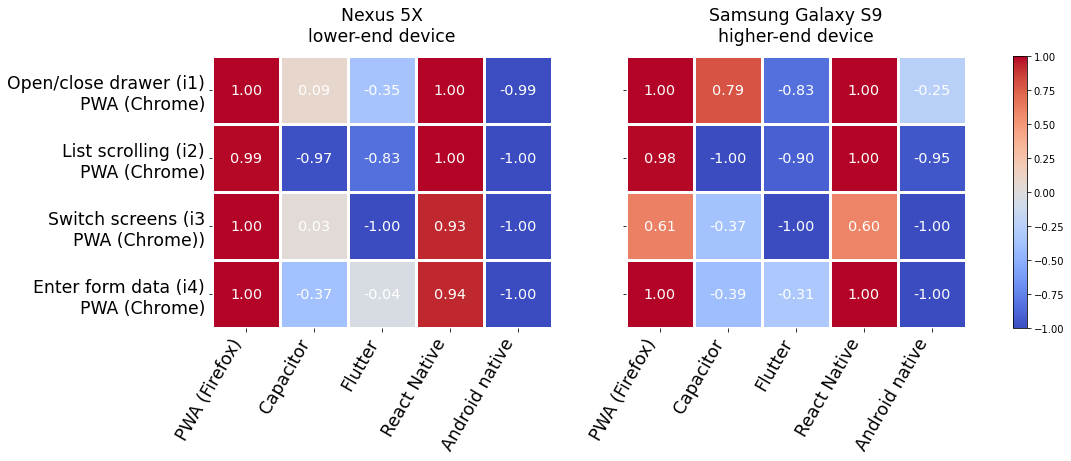

In [12]:
groups = [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5]]

app_names = [    
    "PWA (Firefox)",
    "Capacitor",    
    "Flutter",
    "React Native",    
    "Android native"      
]

interaction_sorting = {
    "Open/close drawer (i1)": 0,   
    "List scrolling (i2)": 1,
    "Switch screens (i3)": 2,
    "Enter form data (i4)": 3,
}

interaction_names = [
    "Open/close drawer (i1)\nPWA (Chrome)",   
    "List scrolling (i2)\nPWA (Chrome)",
    "Switch screens (i3\nPWA (Chrome))",
    "Enter form data (i4)\nPWA (Chrome)",
]

eff_data = {
    "Nexus5X": [[] for i in range(4)],  # rows are interactions, columns are development approaches (aka app)
    "SM-G960F": [[] for i in range(4)]
}

device_labels = {
    "Nexus5X": "Nexus 5X\nlower-end device",
    "SM-G960F": "Samsung Galaxy S9\nhigher-end device"
}

keys = [
    "Nexus5X_OpenCloseDrawerInteractionTest",
    "Nexus5X_ScrollDownListInteractionTest",
    "Nexus5X_SwitchScreensInteractionTest",
    "Nexus5X_EnterFormDataInteractionTest",
    "SM-G960F_OpenCloseDrawerInteractionTest",
    "SM-G960F_ScrollDownListInteractionTest",
    "SM-G960F_SwitchScreensInteractionTest",
    "SM-G960F_EnterFormDataInteractionTest",
]

for key in keys:  
    item = battery_data[key]
    #eff_key = item["device"]
    
    for g, group in enumerate(groups):
        eff = cliff.cliffs_delta(item["data"][group[1]], item["data"][group[0]])
        eff_data[item["device"]][interaction_sorting[item['interaction']]].append(eff[0])
        
fig, axs = plt.subplots(1, 2, sharey=True, sharex=True, squeeze=True, figsize=(17,5))

for i, key in enumerate(["Nexus5X", "SM-G960F"]):
    data = np.array(eff_data[key])
    im = axs[i].imshow(data, cmap="coolwarm")
    
    # remove grid
    for edge, spine in axs[i].spines.items():
        spine.set_visible(False)        
    axs[i].set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    axs[i].set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    axs[i].grid(which="minor", color="w", linestyle='-', linewidth=3)
    axs[i].tick_params(which="minor", bottom=False, left=False)
    
    axs[i].set_title(device_labels[key], fontsize='xx-large', pad=15)    
    axs[i].set_xticks(np.arange(data.shape[1]))
    axs[i].set_yticks(np.arange(data.shape[0]))
    axs[i].set_xticklabels(app_names)
    
    if i == 0:
        axs[i].set_yticklabels(interaction_names)
        
    #plt.setp(axs[i].get_xticklabels(), rotation=-30, ha="right", rotation_mode="anchor")
        
    for c in range(5):
        for r in range(4):
            text = axs[i].text(c, r, "{:.2f}".format(data[r, c]), ha="center", va="center", color="w", fontsize="x-large")
            
fig.colorbar(im, ax=axs, use_gridspec=True)
        
for i in range(2):
    for label in axs[i].get_xticklabels():
        label.set_rotation(60)
        label.set_ha('right')
        label.set_fontsize('xx-large')  
        
for label in axs[0].get_yticklabels():
    label.set_fontsize('xx-large')
        
#fig.subplots_adjust(hspace=0.1)

fig.savefig('figures/heatmap.png', dpi=800, bbox_inches = "tight")